In [1]:
import sys
sys.path.append('../../qick/qick_lib/')
sys.path.append('soft/')

from qick import *
from qick_training import *
from qick.averager_program import QickSweep
from qick.averager_program import merge_sweeps

import numpy as np
from numpy.fft import fft, fftshift
import matplotlib.pyplot as plt

In [2]:
# Load bitstream with custom overlay
soc = QickSoc('./qick_training.bit')
soccfg = soc

print(soccfg)


QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	6 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, envelope memory 4096 samples
		DAC tile 2, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	1:	axis_sg_int4_v1 - tProc output 1, envelope memory 4096 samples
		DAC tile 2, blk 1, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	2:	axis_sg_int4_v1 - tProc output 2, envelope memory 4096 samples
		DAC tile 2, blk 2, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	3:	axis_sg_int4_v1 - tProc output 3, envelope memory 4096 samples
		DAC tile 2, blk 3, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=307.200 MHz, f_dds=4915.200 MHz
	5:	axis_sg_mux4_v1 - tProc output 6, envelope memory 0 samples
		DAC tile 0, blk 0, 16-bit DDS, fabric=307.200 MHz, f_dds=1228.800 MHz

	8 readout channels:
	0:	axis_pf

In [28]:
class GaussGainSweep(NDAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        self.declare_gen(ch=self.cfg["gen_ch"][0], nqz=1)
        self.declare_gen(ch=self.cfg["gen_ch"][1], nqz=1)
        
        # Declare Gaussian Envelope.
        sigma  = self.us2cycles(self.cfg['env_sigma'],gen_ch=self.cfg['gen_ch'][0])
        length = self.us2cycles(self.cfg['env_length'],gen_ch=self.cfg['gen_ch'][0])
        self.add_gauss(ch=self.cfg['gen_ch'][0], name=self.cfg['env_name'], sigma=sigma, length=length)
        
        # First channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][0], gen_ch=self.cfg['gen_ch'][0])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][0], 
                                     freq   = freq,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'][0], 
                                     )
        
        # Second channel.
        freq = self.freq2reg(self.cfg['pulse_freq'][1], gen_ch=self.cfg['gen_ch'][1])
        self.default_pulse_registers(ch     = self.cfg['gen_ch'][1], 
                                     style  = 'const', 
                                     freq   = freq,
                                     phase  = 0,
                                     gain   = self.cfg['pulse_gain'][1], 
                                     length = self.us2cycles(self.cfg['pulse_length'],gen_ch=self.cfg['gen_ch'][1]))        
        
        # Sweep defination
        self.res_r_gain = self.get_gen_reg(self.cfg['gen_ch'][1], 'gain')        

        # Add gain sweep.
        gstart = int(self.cfg['pulse_gain'][1] * self.cfg['g_start'])
        gstop  = int(self.cfg['pulse_gain'][1] * self.cfg['g_stop'])
        self.add_sweep(QickSweep(self, self.res_r_gain, gstart, gstop, self.cfg["g_expts"]))

        self.synci(200)  # give processor some time to configure pulses

    def body(self):
        # Registers.
        self.set_pulse_registers(ch=self.cfg['gen_ch'][0], phrst=1, style='arb', waveform=self.cfg['env_name'])
        self.set_pulse_registers(ch=self.cfg['gen_ch'][1], phrst=1, mode="oneshot")
        
        # Trigger.
        self.trigger(pins=[0],t=40)

        # Pulses.
        self.pulse(ch     = self.cfg['gen_ch'][0],
                   t      = self.us2cycles(self.cfg['pulse_start'][0], gen_ch = self.cfg['gen_ch'][0]))
        
        self.pulse(ch     = self.cfg['gen_ch'][1],
                   t      = self.us2cycles(self.cfg['pulse_start'][1], gen_ch = self.cfg['gen_ch'][1]))                 
        
        
        # Period.
        self.synci(self.us2cycles(self.cfg['period']))

In [47]:
config={"gen_ch"      : [1,3],
        "reps"        : 200000000,
        "pulse_length": 3,
        "pulse_start" : [0,0],
        "pulse_gain"  : [30000,30000], # [DAC units]
        "pulse_freq"  : [0.1,3], # [MHz]
        "period"      : 10,
        "env_sigma"   : 1,
        "env_length"  : 3,
        "env_name"    : 'gauss'
       }


expt_cfg = {
    "g_start": 0.2,  # [DAC units]
    "g_stop": 0.9,  # [DAC units]
    "g_expts": 2,
}

config.update(**expt_cfg)

prog = GaussGainSweep(soccfg, config)
prog.config_all(soccfg)
soc.tproc.start()

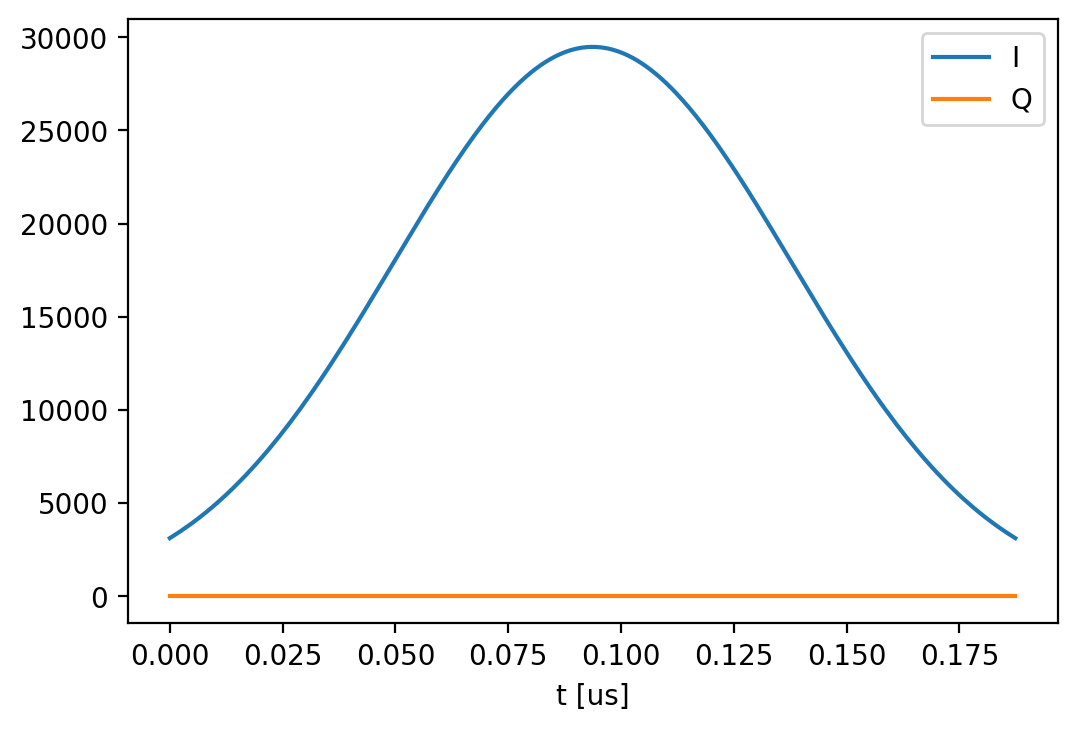

In [31]:
# Plot Gaussian Envelope.
plt.figure(dpi=200)

# fs (MHz) and ts (us).
fs = soccfg['gens'][config['gen_ch'][0]]['fs']
ts = 1/fs

# Pulse data.
y = prog.pulses[config['gen_ch'][0]][config['env_name']]['data']
x = ts*np.arange(len(y))
plt.plot(x,y);
plt.xlabel('t [us]');
plt.legend(['I','Q']);